## IMPORT PRE-PROCESSED DATA & SUBSET

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('NSDUH PROCESSED2.csv')

C:\Users\david\AppData\Local\Temp\ipykernel_23856\2478691757.py:1: DtypeWarning: Columns (4,7,10,22,25,34,37,38,39,41,42,43,45,46,47,49,50,51,57,58,59,61,62,63,64,66,67,68,69,70,85,87,89,90,92,93,110,113,118,119,120,137,150) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('NSDUH PROCESSED2.csv')


In [4]:
df = df.applymap(str)

In [5]:
for cols in df.columns:
    mask = (df[cols] == 'nan')
    
    df.loc[mask, cols] = np.nan

In [6]:
#check number of columns with missing data
len(df.columns[df.isnull().any()])

129

In [7]:
df.head()

,CIGEVER,CIGTRY,CIGREC,CIGAGE,CIGAREVR,CIGARTRY,CIGARREC,SMKLSSEVR,SMKLSSTRY,SMKLSSREC,...,CHAMPUS,PRVHLTIN,CELLWRKNG,GOVTPROG,INCOME,PDEN10,COUTYP4,MAIIN102,AIIND102,METHAMEVR
0,1,less than 18,1,18 or older,1,18 or older,4,1,less than 18,1,...,2,1,1,0,4,3,3,0,0,0
1,1,less than 18,1,18 or older,2,0,0,1,less than 18,4,...,2,1,1,0,3,2,2,0,0,0
2,0,0,0,0,2,0,0,2,0,0,...,2,1,1,0,2,1,1,0,0,0
3,0,0,0,0,2,0,0,2,0,0,...,2,1,1,0,4,1,1,0,0,0
4,0,0,0,0,2,0,0,2,0,0,...,2,1,1,0,2,2,2,0,0,0


In [8]:
df = df.dropna()

In [9]:
#check number of columns with missing data
len(df.columns[df.isnull().any()])

0

In [10]:
df_backup = df.copy()

In [11]:
# df = df_backup.copy()

In [11]:
df['METHAMEVR'].value_counts()

0    22306
1     1148
Name: METHAMEVR, dtype: int64

In [12]:
df['COCAGE'].value_counts()

0               20146
18 or older      2655
less than 18      650
unknown             3
Name: COCAGE, dtype: int64

# PYCARET MODELING

In [13]:
from pycaret.classification import *

In [14]:
from imblearn.under_sampling import *
from imblearn.over_sampling import *
oversample = RandomOverSampler(sampling_strategy='minority', random_state=123)
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=123)
SMOTE = SMOTE(sampling_strategy='minority', random_state=123)

## Under sampling

In [15]:
s = setup(df, target = 'METHAMEVR',  session_id=123, silent=True, fix_imbalance=True, 
          fix_imbalance_method=undersample,
          imputation_type = 'iterative', categorical_iterative_imputer='knn')

,Description,Value
0,session_id,123
1,Target,METHAMEVR
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(23454, 158)"
5,Missing Values,0
6,Numeric Features,0
7,Categorical Features,157
8,Ordinal Features,0
9,High Cardinality Features,0


In [16]:
from sklearn.metrics import average_precision_score
add_metric('apc', 'APC', average_precision_score, target = 'pred_proba')

Name                                                               APC
Display Name                                                       APC
Score Function       <function average_precision_score at 0x0000016...
Scorer               make_scorer(average_precision_score, needs_pro...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: apc, dtype: object

In [17]:
#due to imbalance learning problem, our chosen metric for comparison is the F1-score
best = compare_models(sort='APC', n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
catboost,CatBoost Classifier,0.8770,0.9468,0.8817,0.2635,0.4054,0.3586,0.4412,0.5468,1.3660
rf,Random Forest Classifier,0.8679,0.9441,0.8921,0.2508,0.3913,0.3426,0.4307,0.5160,0.0890
gbc,Gradient Boosting Classifier,0.8734,0.9410,0.8753,0.2570,0.3971,0.3493,0.4324,0.5119,0.1850
lightgbm,Light Gradient Boosting Machine,0.8698,0.9387,0.8701,0.2505,0.3887,0.3401,0.4240,0.5117,0.1360
et,Extra Trees Classifier,0.8678,0.9441,0.8844,0.2492,0.3887,0.3398,0.4269,0.5002,0.0830
xgboost,Extreme Gradient Boosting,0.8642,0.9368,0.8804,0.2435,0.3813,0.3317,0.4195,0.4938,0.3640
lr,Logistic Regression,0.8591,0.9245,0.8342,0.2297,0.3601,0.3087,0.3910,0.4825,0.4840
ada,Ada Boost Classifier,0.8763,0.9359,0.8521,0.2584,0.3962,0.3488,0.4270,0.4812,0.1090
lda,Linear Discriminant Analysis,0.8674,0.9057,0.8149,0.2379,0.3682,0.3182,0.3947,0.4100,0.1170
knn,K Neighbors Classifier,0.9271,0.8928,0.6540,0.3564,0.4598,0.4245,0.4479,0.3687,0.4730


In [18]:
print(best)

[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform'), <catboost.core.CatBoostClassifier object at 0x00000273C6513100>, GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), AdaBoostClassifier(algorithm='SAMME.R', base_estima

In [20]:
evaluate_model(best[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Random Forest

In [25]:
#Focus on Tree Based Ensembles so we can evaluate feature importance
#random forest
rf = create_model('rf', return_train_score=True)

In [26]:
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [27]:
#tune rf
tuned_rf, tuner = tune_model(rf, optimize = 'APC', return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.8946,0.9538,0.8462,0.2907,0.4328,0.3896,0.4580,0.5595
1,0.8873,0.9299,0.8205,0.2723,0.4089,0.3635,0.4320,0.6114
2,0.8843,0.9389,0.7949,0.2627,0.3949,0.3484,0.4145,0.4814
3,0.9013,0.9554,0.8846,0.3108,0.4600,0.4192,0.4894,0.5624
4,0.8910,0.9285,0.8205,0.2795,0.4169,0.3725,0.4390,0.5054
5,0.8867,0.9579,0.8974,0.2823,0.4294,0.3850,0.4655,0.6008
6,0.9026,0.9512,0.8718,0.3119,0.4595,0.4188,0.4864,0.5580
7,0.9019,0.9523,0.8442,0.3037,0.4467,0.4057,0.4703,0.6159
8,0.8976,0.9400,0.8312,0.2922,0.4324,0.3901,0.4552,0.5131


In [28]:
predict_model(tuned_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Random Forest Classifier,0.8914,0.9545,0.9000,0.3142,0.4657,0.4206,0.4935,0.6056


,CIGTRY_18 or older,CIGTRY_less than 18,CIGTRY_unknown,CIGREC_1,CIGREC_2,CIGREC_3,CIGREC_4,CIGREC_others,CIGAGE_18 or older,CIGAGE_less than 18,...,PDEN10_2,PDEN10_3,COUTYP4_1,COUTYP4_2,COUTYP4_3,MAIIN102_0,AIIND102_0,METHAMEVR,Label,Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.8372
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.7173
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.6644
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.6620
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.7081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5888
7033,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.6521
7034,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.5726
7035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5548


In [29]:
print(tuner)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('fix_imbalance',
                                              RandomUnderSampler(random_state=123,
                                                                 replacement=False,
                                                                 sampling_strategy='majority')),
                                             ('actual_estimator',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_...
             

In [30]:
#compare tuned rf with default
print('Default: ', rf)
print('Tuned: ', tuned_rf)

Default:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)
Tuned:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
              

In [31]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

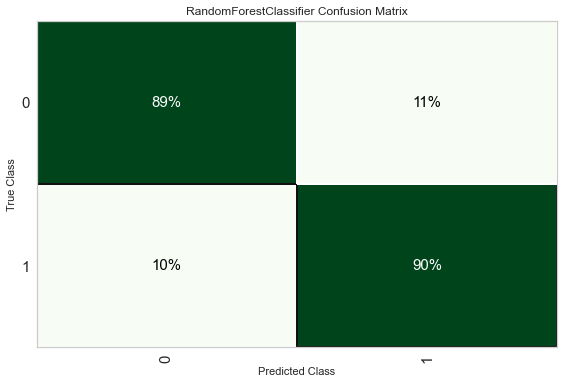

In [38]:
plot_model(tuned_rf, plot='confusion_matrix', plot_kwargs = {'percent': True})

### Catboost

In [18]:
#catboost
catboost = create_model('catboost', return_train_score=True)

In [20]:
#tune catboost
tuned_catboost, tuner = tune_model(catboost, optimize='APC', return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.8806,0.9488,0.8590,0.2659,0.4061,0.3596,0.4371,0.5970
1,0.8855,0.9424,0.8205,0.2689,0.4051,0.3592,0.4285,0.5959
2,0.8745,0.9428,0.8462,0.2538,0.3905,0.3425,0.4208,0.4850
3,0.8940,0.9597,0.8974,0.2966,0.4459,0.4032,0.4798,0.5471
4,0.8886,0.9240,0.8205,0.2747,0.4116,0.3665,0.4343,0.5163
5,0.8825,0.9520,0.8846,0.2727,0.4169,0.3713,0.4519,0.5272
6,0.8922,0.9539,0.8846,0.2911,0.4381,0.3948,0.4704,0.5470
7,0.9007,0.9583,0.8961,0.3080,0.4585,0.4178,0.4909,0.5848
8,0.8879,0.9389,0.8182,0.2704,0.4065,0.3614,0.4299,0.5067


In [22]:
predict_model(tuned_catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,CatBoost Classifier,0.8845,0.9538,0.9108,0.3017,0.4533,0.4064,0.4848,0.6050


,CIGTRY_18 or older,CIGTRY_less than 18,CIGTRY_unknown,CIGREC_1,CIGREC_2,CIGREC_3,CIGREC_4,CIGREC_others,CIGAGE_18 or older,CIGAGE_less than 18,...,PDEN10_2,PDEN10_3,COUTYP4_1,COUTYP4_2,COUTYP4_3,MAIIN102_0,AIIND102_0,METHAMEVR,Label,Score
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.9917
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0.9541
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9176
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.8847
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,0.9609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5942
7033,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.8300
7034,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,1,0.5435
7035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0.5641


In [23]:
print(tuner)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('fix_imbalance',
                                              RandomUnderSampler(random_state=123,
                                                                 replacement=False,
                                                                 sampling_strategy='majority')),
                                             ('actual_estimator',
                                              <catboost.core.CatBoostClassifier object at 0x0000016EC2571520>)],
                                      verbose=False),
                   iid='deprecat...
                                                                           20,
                                                                           30,
                                                                         

In [69]:
#compare tuned model with default
print(catboost)
print(tuned_catboost)

In [24]:
evaluate_model(tuned_catboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Adaboost

In [71]:
#adaboost
ada = create_model('ada', return_train_score=True)

In [72]:
#tune catboost
tuned_ada, tuner = tune_model(ada, optimize='F1', return_tuner=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8861,0.9469,0.8590,0.2757,0.4174,0.3723,0.4471
1,0.8916,0.9417,0.8077,0.2788,0.4145,0.3700,0.4343
2,0.8831,0.9434,0.8462,0.2683,0.4074,0.3613,0.4357
3,0.9019,0.9586,0.8718,0.3105,0.4579,0.4171,0.4850
4,0.8971,0.9253,0.7949,0.2884,0.4232,0.3800,0.4395
5,0.8879,0.9529,0.8846,0.2828,0.4286,0.3842,0.4621
6,0.9001,0.9531,0.8718,0.3063,0.4533,0.4120,0.4811
7,0.9037,0.9585,0.8831,0.3134,0.4626,0.4226,0.4918
8,0.9013,0.9404,0.8052,0.2967,0.4336,0.3919,0.4511


In [73]:
print(tuner)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('fix_imbalance',
                                              RandomUnderSampler(random_state=123,
                                                                 replacement=False,
                                                                 sampling_strategy='majority')),
                                             ('actual_estimator',
                                              AdaBoostClassifier(algorithm='SAMME.R',
                                                                 base_estimator=None,
                                                                 learning_rate=1.0,
                                                                 n_estimators=5...
                                                                            1e-06,
            

In [74]:
#compare tuned model with default
print(ada)
print(tuned_ada)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=123)
AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.2,
                   n_estimators=230, random_state=123)


In [75]:
evaluate_model(tuned_ada)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…